# Dynamic Risk Budgeting

In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
n_scenarios = 5000
rates, zc_prices = erk.cir(n_years=10, n_scenarios=n_scenarios, b=0.03, r_0=0.03, sigma=0.02)
price_eq = erk.gbm(n_years=10, n_scenarios=n_scenarios, mu=0.07, sigma=0.15)

In [3]:
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)
pd.concat([
    erk.terminal_stats(rets_zc, name='ZC', floor=0.75),
    erk.terminal_stats(rets_eq, name='Eq', floor=0.75),
    erk.terminal_stats(rets_7030b, name='70/30', floor=0.75)
], axis=1).round(2)

,ZC,Eq,70/30
mean,1.34,1.98,1.76
std,0.00,0.97,0.59
p_breach,NaN,0.03,0.01
e_short,NaN,0.11,0.08
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


In [4]:
rets_floor75 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75, zc_prices=zc_prices[1:])
pd.concat([erk.terminal_stats(rets_zc, name='ZC', floor=0.75),
           erk.terminal_stats(rets_eq, name='Eq', floor=0.75),
           erk.terminal_stats(rets_7030b, name='70/30', floor=0.75),
           erk.terminal_stats(rets_floor75, name='Floor75', floor=0.75)
          ], axis=1).round(2)

,ZC,Eq,70/30,Floor75
mean,1.34,1.98,1.76,1.95
std,0.00,0.97,0.59,0.98
p_breach,NaN,0.03,0.01,NaN
e_short,NaN,0.11,0.08,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [7]:
rets_floor75m1 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75, zc_prices=zc_prices[1:], m=1)
rets_floor75m5 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75, zc_prices=zc_prices[1:], m=5)
rets_floor75m7 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75, zc_prices=zc_prices[1:], m=7)
pd.concat([erk.terminal_stats(rets_zc, name='ZC', floor=0.75),
           erk.terminal_stats(rets_eq, name='Eq', floor=0.75),
           erk.terminal_stats(rets_7030b, name='70/30', floor=0.75),
           erk.terminal_stats(rets_floor75, name='Floor75', floor=0.75),
           erk.terminal_stats(rets_floor75m1, name='Floor75m1', floor=0.75),
           erk.terminal_stats(rets_floor75m5, name='Floor75m5', floor=0.75),
           erk.terminal_stats(rets_floor75m7, name='Floor75m7', floor=0.75)
          ], axis=1).round(4)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5,Floor75m7
mean,1.3433,1.9799,1.7646,1.9549,1.6264,1.9654,1.9674
std,0.0000,0.9681,0.5882,0.9759,0.4272,0.9778,0.9778
p_breach,NaN,0.0312,0.0052,NaN,NaN,NaN,0.0020
e_short,NaN,0.1069,0.0781,NaN,NaN,NaN,0.0037
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Risk Budgeting with Drawdown Constraints

In [16]:
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12)-1
rets_cash = pd.DataFrame(data=monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = erk.bt_mix(rets_eq, rets_cash, allocator=erk.drawdown_allocator, maxdd=.25)
pd.concat([erk.terminal_stats(rets_zc, name='ZC', floor=0.75),
           erk.terminal_stats(rets_eq, name='Eq', floor=0.75),
           erk.terminal_stats(rets_7030b, name='70/30', floor=0.75),
           erk.terminal_stats(rets_floor75, name='Floor75', floor=0.75),
           erk.terminal_stats(rets_floor75m1, name='Floor75m1', floor=0.75),
           erk.terminal_stats(rets_floor75m5, name='Floor75m5', floor=0.75),
           erk.terminal_stats(rets_floor75m7, name='Floor75m7', floor=0.75),
           erk.terminal_stats(rets_maxdd25, name='MaxDD25', floor=0.75)
          ], axis=1).round(4)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5,Floor75m7,MaxDD25
mean,1.3433,1.9799,1.7646,1.9549,1.6264,1.9654,1.9674,1.6342
std,0.0000,0.9681,0.5882,0.9759,0.4272,0.9778,0.9778,0.5361
p_breach,NaN,0.0312,0.0052,NaN,NaN,NaN,0.0020,NaN
e_short,NaN,0.1069,0.0781,NaN,NaN,NaN,0.0037,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
erk.summary_stats(rets_maxdd25)['Max Drawdown']

0      -0.212284
1      -0.191137
2      -0.181947
3      -0.115779
4      -0.123608
          ...   
4995   -0.152268
4996   -0.142016
4997   -0.200207
4998   -0.216121
4999   -0.138993
Name: Max Drawdown, Length: 5000, dtype: float64

In [19]:
erk.summary_stats(rets_maxdd25)['Max Drawdown'].min()

-0.235660744335859

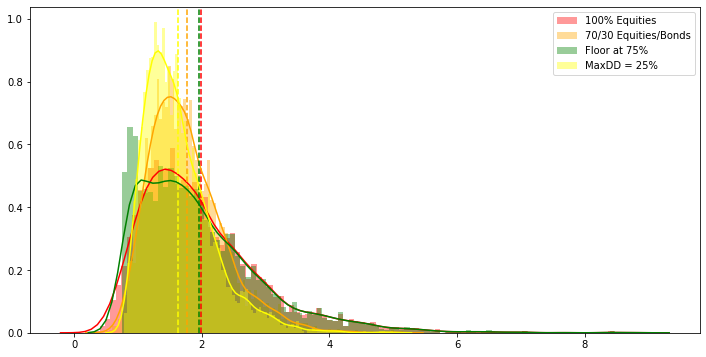

In [23]:
# Calculate terminal values
tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030b = erk.terminal_values(rets_7030b)
tv_floor75 = erk.terminal_values(rets_floor75)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)
# Plot
plt.figure(figsize=(12, 6))
sns.distplot(tv_eq, color='red', label='100% Equities', bins=100)
plt.axvline(tv_eq.mean(), ls='--', color='red')
sns.distplot(tv_7030b, color='orange', label='70/30 Equities/Bonds', bins=100)
plt.axvline(tv_7030b.mean(), ls='--', color='orange')
sns.distplot(tv_floor75, color='green', label='Floor at 75%', bins=100)
plt.axvline(tv_floor75.mean(), ls='--', color='green')
sns.distplot(tv_maxdd25, color='yellow', label='MaxDD = 25%', bins=100)
plt.axvline(tv_maxdd25.mean(), ls='--', color='yellow')
plt.legend();

## Drawdown constraint with Historical Data

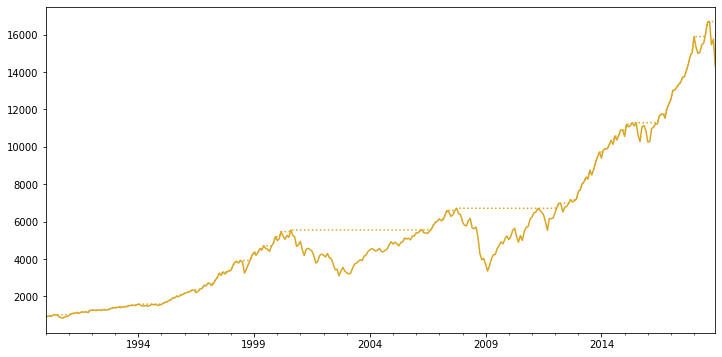

In [24]:
rets_tmi = erk.get_total_market_index_returns()['1990':]
dd_tmi = erk.drawdown(rets_tmi)
ax = dd_tmi['wealth'].plot(figsize=(12, 6), ls='-', color='goldenrod')
dd_tmi['peaks'].plot(ax=ax, ls=':', color='goldenrod')

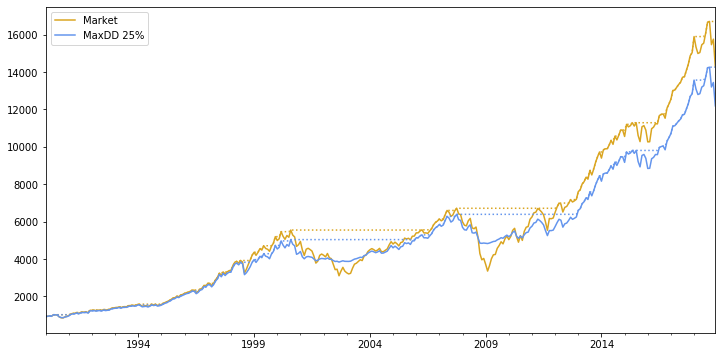

In [26]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12)-1
rets_cash = pd.DataFrame(data=monthly_cashreturn, index=rets_tmi.index, columns=[0])
rets_maxdd25 = erk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=erk.drawdown_allocator, maxdd=.25, m=5)
dd_25 = erk.drawdown(rets_maxdd25[0])

ax = dd_tmi['wealth'].plot(figsize=(12, 6), ls='-', color='goldenrod', label='Market', legend=True)
dd_tmi['peaks'].plot(ax=ax, ls=':', color='goldenrod')
dd_25['wealth'].plot(ax=ax, label='MaxDD 25%', color='cornflowerblue', legend=True)
dd_25['peaks'].plot(ax=ax, ls=':', color='cornflowerblue')

In [28]:
erk.summary_stats(pd.concat([rets_tmi.rename('Market'), rets_maxdd25[0].rename('MaxDD')], axis=1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Market,0.096058,0.145419,-0.668827,4.247282,0.066949,0.094633,0.441951,-0.499943
MaxDD,0.090062,0.112755,-0.630463,5.015334,0.049978,0.071074,0.518327,-0.244212
